<a href="https://colab.research.google.com/github/namwootree/Portfolio/blob/main/Competition/Kaggle/Scrabble%20Player%20Rating/Catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

## Install

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 4.6 MB/s 
     |████████████████████████████████| 209 kB 43.3 MB/s 
     |████████████████████████████████| 78 kB 3.5 MB/s 
     |████████████████████████████████| 50 kB 3.6 MB/s 
     |████████████████████████████████| 147 kB 15.1 MB/s 
     |████████████████████████████████| 112 kB 37.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=7c1aedfc0a9dc6473f444a955582e2ad12760449e3c84e207fc622eb535260ea
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 23 kB/s 


## Library

In [10]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
import os


from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, GroupKFold

from catboost import CatBoostRegressor
from catboost import Pool, cv

import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

# Load Data

## Google Drive Mount

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip File

## Load Train / Test Set

In [8]:
X = pd.read_csv('/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/data/X_train.csv')
y = pd.read_csv('/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/data/y_train.csv')
y = y['rating']
X_test = pd.read_csv('/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/data/X_test.csv')

# Modeling

## Optuna

In [9]:
groups = X.pop('nickname')

In [11]:
def objective(trial, X, y):

    cv_dataset = Pool(data=X,
                   label=y)
    
    # 적용(수색)할 최적의 하이퍼 파라미터 범위 지정
    param = {
    'loss_function':'RMSE',
    'depth':7,
    'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
    #"max_depth":trial.suggest_int("max_depth", 4, 16),
    'random_strength' :trial.suggest_int('random_strength', 0, 126),
    'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
    "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.3, 1.0),
    "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
    "min_child_samples": trial.suggest_int("min_child_samples", 1, 512),
    "max_bin": trial.suggest_int("max_bin", 100, 512)
    }

    folds = GroupKFold(n_splits=5).split(X, y, groups=groups)

    scores = cv(cv_dataset,
                param,
                folds= folds,
                verbose=100,                   
                early_stopping_rounds=100, 
                num_boost_round=50000)
    
    cv_score = list(scores['test-RMSE-mean'])[-1]

    # Return metric of interest
    return cv_score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X, y),
               timeout=5000,
               n_trials=100,
               n_jobs=1,
               show_progress_bar=True) 

  0%|          | 0/100 [00:00<?, ?it/s]

Training on fold [0/5]
0:	learn: 1797.3391353	test: 1547.6371404	best: 1547.6371404 (0)	total: 120ms	remaining: 1h 40m 14s
100:	learn: 146.5606310	test: 155.1311421	best: 133.6462473 (80)	total: 5.18s	remaining: 42m 40s

bestTest = 133.6462473
bestIteration = 80

Training on fold [1/5]
0:	learn: 1753.8729353	test: 1741.5673060	best: 1741.5673060 (0)	total: 63ms	remaining: 52m 27s
100:	learn: 143.5135590	test: 152.7026483	best: 152.7026483 (100)	total: 6.27s	remaining: 51m 36s
200:	learn: 93.3493488	test: 111.6379476	best: 111.6379476 (200)	total: 11.8s	remaining: 48m 50s
300:	learn: 84.8166153	test: 107.8092699	best: 107.8092699 (300)	total: 17.5s	remaining: 48m 4s
400:	learn: 78.4385182	test: 106.4794150	best: 106.4194703 (398)	total: 24s	remaining: 49m 31s
500:	learn: 68.2288069	test: 105.3735783	best: 105.3735783 (500)	total: 30.7s	remaining: 50m 30s
600:	learn: 61.6123560	test: 105.3235445	best: 105.1472648 (535)	total: 38.3s	remaining: 52m 29s

bestTest = 105.1472648
bestIteration

In [ ]:
print(study.best_params)

In [ ]:
print(study.best_value**0.5)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

## Group KFold

In [ ]:
preds = []

test_groups = X_test.pop('nickname') 

num_fold = 0

for repeat in range(3):

  for fold_idx, (train_index, valid_index) in enumerate(tqdm(skf.split(X, y))):
      X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
      y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

      cat_params = {
          'verbose': 500,
          'n_estimators': 50000,
          **study.best_params
      }

      print(f'\nNumber fold : {num_fold}\n')

      model = CatBoostRegressor(**cat_params,
                                task_type='CPU')

      model.fit(X_train, y_train,
                eval_set=(X_valid, y_valid),
                early_stopping_rounds=100,
                use_best_model=True,
                  verbose=500)
      
      y_pred = model.predict(X_valid)

      score = mean_squared_error(y_valid, y_pred, squared=False)

      print("\nFold {} MSE Score: {}\n".format(fold_idx, score))
      print("\n----------------------\n")

      preds.append( model.predict(X_test))

      num_fold += 1

0it [00:00, ?it/s]


Number fold : 0

0:	learn: 208.0424218	test: 206.8693720	best: 206.8693720 (0)	total: 20.2ms	remaining: 16m 50s
500:	learn: 79.6254335	test: 81.7229269	best: 81.7229269 (500)	total: 8.74s	remaining: 14m 23s
1000:	learn: 66.3284681	test: 71.9726816	best: 71.9726816 (1000)	total: 17.3s	remaining: 14m 8s
1500:	learn: 60.0708251	test: 68.1404124	best: 68.1404124 (1500)	total: 25.8s	remaining: 13m 52s
2000:	learn: 56.0832070	test: 65.8393844	best: 65.8393844 (2000)	total: 33.9s	remaining: 13m 33s
2500:	learn: 53.1674760	test: 64.2201443	best: 64.2201443 (2500)	total: 42.2s	remaining: 13m 21s
3000:	learn: 50.8609234	test: 63.0587627	best: 63.0587627 (3000)	total: 50.4s	remaining: 13m 9s
3500:	learn: 49.0830890	test: 62.2327615	best: 62.2327615 (3500)	total: 58.6s	remaining: 12m 58s
4000:	learn: 47.5535145	test: 61.5098592	best: 61.5098592 (4000)	total: 1m 6s	remaining: 12m 46s
4500:	learn: 46.2108996	test: 60.8526052	best: 60.8521467 (4498)	total: 1m 14s	remaining: 12m 36s
5000:	learn: 44.9

# Submission

In [ ]:
final_preds = np.mean(preds, axis=0)

Text(0.5, 1.0, 'Distribution of Predicted Ratings')

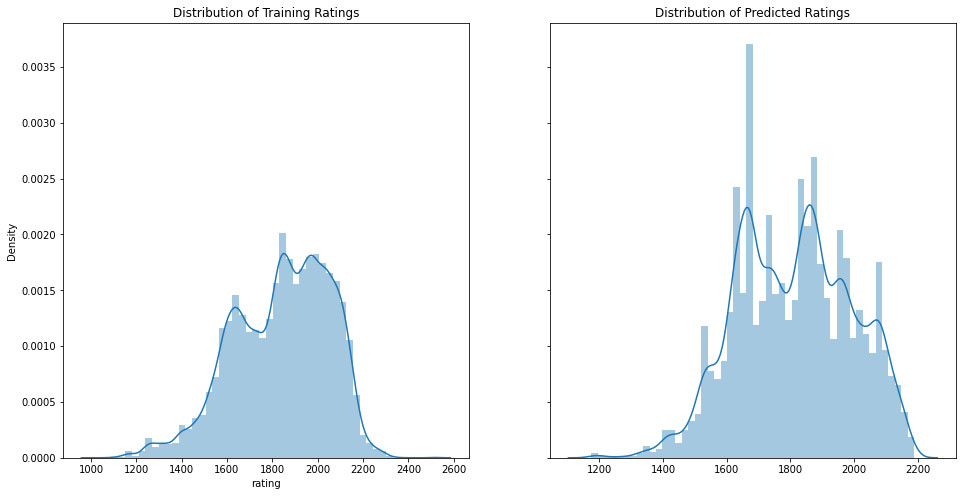

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,8))
sns.distplot(y, ax=axs[0])
axs[0].set_title("Distribution of Training Ratings")
sns.distplot(final_preds , ax=axs[1])
axs[1].set_title("Distribution of Predicted Ratings")

In [ ]:
X_test['rating'] = final_preds
submission = X_test[['game_id', 'rating']].set_index('game_id')

path_save = '/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/submission/'
submission.to_csv(path_save + "CAT_1.csv")

In [ ]:
submission

game_id
2        1968.136280
7        1907.014662
11       1839.002818
14       1815.637232
27       2077.094040
            ...     
72760    2086.251512
72761    1741.224014
72762    1554.077298
72768    2039.532111
72769    1850.750837
Name: rating, Length: 22363, dtype: float64